# 06. Kaggle Submission

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("=== KAGGLE SUBMISSION PREPARATION ===")

# 1. Load the final model and data
try:
    # Load the tuned model from previous notebook
    print("Loading model...")
    model = joblib.load('../data/final_tuned_model.pkl')  # or housing_model_package.joblib
    
    # Load processed data
    print("Loading processed data...")
    with open('../data/processed_data.pkl', 'rb') as f:
        data = pickle.load(f)
    
    X_test = data['X_test']
    test_ID = data['test_ID']
    
    # Also load original test data for reference
    test_original = pd.read_csv('../data/test.csv')

    # Standardize column names to lowercase with underscores
    train_original.columns = train_original.columns.str.lower().str.replace(' ', '_')
    
    print("Data and model loaded successfully!")
except Exception as e:
    print(f"Error loading data: {e}")

=== KAGGLE SUBMISSION PREPARATION ===
Loading model...
Loading processed data...
Error loading data: name 'train_original' is not defined


## 1. Generate Predictions


Generating predictions...
Number of predictions: 878
Mean predicted price: $178546.55
Min predicted price: $37590.49
Max predicted price: $521578.82
Number of negative predictions: 0
Number of unusually high predictions (>$1M): 0


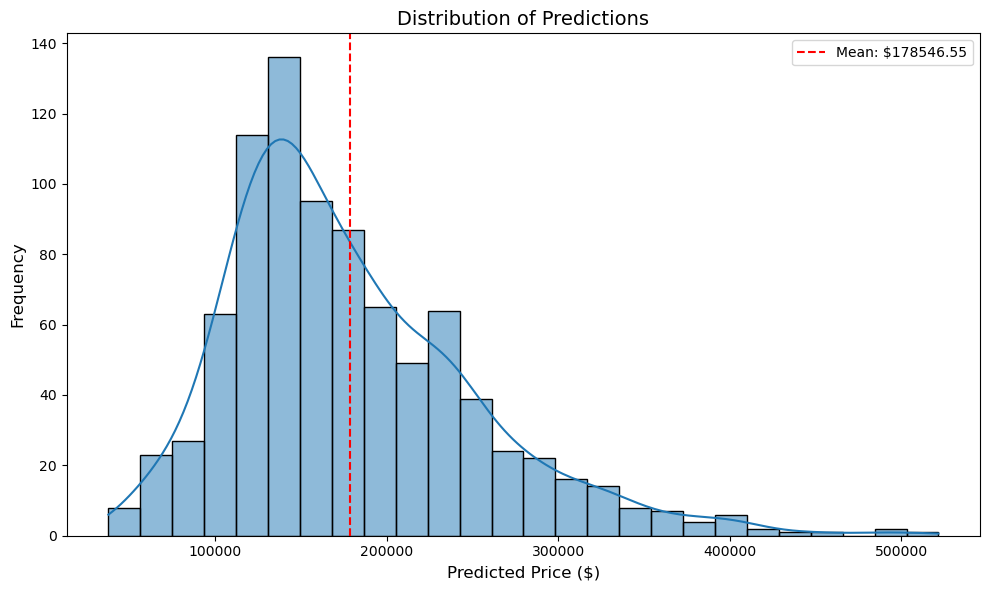

In [3]:
# Generate predictions on test set
print("\nGenerating predictions...")
test_predictions = model.predict(X_test)

# Basic statistics of predictions
print(f"Number of predictions: {len(test_predictions)}")
print(f"Mean predicted price: ${np.mean(test_predictions):.2f}")
print(f"Min predicted price: ${np.min(test_predictions):.2f}")
print(f"Max predicted price: ${np.max(test_predictions):.2f}")

# Check for any invalid predictions
print(f"Number of negative predictions: {np.sum(test_predictions < 0)}")
print(f"Number of unusually high predictions (>$1M): {np.sum(test_predictions > 1000000)}")

# Visualize prediction distribution
plt.figure(figsize=(10, 6))
sns.histplot(test_predictions, kde=True)
plt.title('Distribution of Predictions', fontsize=14)
plt.xlabel('Predicted Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(np.mean(test_predictions), color='red', linestyle='--', label=f'Mean: ${np.mean(test_predictions):.2f}')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Validate Predictions

In [4]:
# Validate predictions for reasonableness
print("\nValidating predictions...")

# Check for outliers using Z-score
z_scores = (test_predictions - np.mean(test_predictions)) / np.std(test_predictions)
outliers = np.abs(z_scores) > 3
num_outliers = np.sum(outliers)
print(f"Number of outlier predictions (|z-score| > 3): {num_outliers}")

if num_outliers > 0:
    print("Examining outlier predictions:")
    outlier_indices = np.where(outliers)[0]
    for idx in outlier_indices:
        test_id = test_ID.iloc[idx]
        prediction = test_predictions[idx]
        z = z_scores[idx]
        print(f"ID: {test_id}, Prediction: ${prediction:.2f}, Z-score: {z:.2f}")
        
        # Show features for this house - using standardized column names
        print("Key features of this house:")
        for feature in ['overall_qual', 'gr_liv_area', 'total_bsmt_sf', 'garage_cars', 'year_built']:
            if feature in test_original.columns:
                value = test_original.loc[test_original['id'] == test_id, feature].values
                if len(value) > 0:
                    print(f"  - {feature}: {value[0]}")
        print()

# If there are problematic predictions, you might want to adjust them
# For example, clip very high/low values or manually review specific cases
print("\nApplying final adjustments...")
adjusted_predictions = np.clip(test_predictions, 10000, 1000000)  # Clip to reasonable range

# Check if any predictions were adjusted
num_adjusted = np.sum(adjusted_predictions != test_predictions)
print(f"Number of predictions adjusted: {num_adjusted}")


Validating predictions...
Number of outlier predictions (|z-score| > 3): 11
Examining outlier predictions:
ID: 1064, Prediction: $442305.70, Z-score: 3.63
Key features of this house:

ID: 2446, Prediction: $495886.16, Z-score: 4.37
Key features of this house:

ID: 433, Prediction: $451495.99, Z-score: 3.76
Key features of this house:

ID: 1761, Prediction: $485555.14, Z-score: 4.23
Key features of this house:

ID: 422, Prediction: $412630.97, Z-score: 3.22
Key features of this house:

ID: 2401, Prediction: $414600.04, Z-score: 3.25
Key features of this house:

ID: 431, Prediction: $406971.38, Z-score: 3.14
Key features of this house:

ID: 1768, Prediction: $521578.82, Z-score: 4.72
Key features of this house:

ID: 1692, Prediction: $399168.98, Z-score: 3.04
Key features of this house:

ID: 2342, Prediction: $402793.47, Z-score: 3.09
Key features of this house:

ID: 2336, Prediction: $403113.87, Z-score: 3.09
Key features of this house:


Applying final adjustments...
Number of predict

## 3. Prepare Submission File

In [5]:
# Create submission file
print("\nPreparing submission file...")

# Create DataFrame for submission
submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': adjusted_predictions
})

# Check submission format
print("Submission dataframe shape:", submission.shape)
print("First few rows:")
print(submission.head())

# Check for missing values
if submission.isnull().any().any():
    print("WARNING: Submission contains null values!")
    # Fill missing values with median prediction if any
    submission['SalePrice'] = submission['SalePrice'].fillna(submission['SalePrice'].median())
else:
    print("No missing values in submission.")

# Round prices to 2 decimal places (optional)
submission['SalePrice'] = submission['SalePrice'].round(2)

# Validate against sample submission format
try:
    sample_sub = pd.read_csv('../data/sample_sub_reg.csv')
    # Standardize column names if needed
    if not all(col.islower() for col in sample_sub.columns):
        sample_sub.columns = sample_sub.columns.str.lower().str.replace(' ', '_')
    
    # Check if IDs match
    if set(sample_sub['id']) != set(submission['Id']):
        print("WARNING: Submission IDs don't match sample submission IDs!")
        # Adjust column name if needed
        if 'Id' in submission.columns and 'id' in sample_sub.columns:
            submission = submission.rename(columns={'Id': 'id'})
        
        missing_ids = set(sample_sub['id']) - set(submission['id'])
        extra_ids = set(submission['id']) - set(sample_sub['id'])
        
        if missing_ids:
            print(f"Missing {len(missing_ids)} IDs in submission")
        if extra_ids:
            print(f"Extra {len(extra_ids)} IDs in submission")
    else:
        print("All IDs match the sample submission format.")
    
    # Rename column if needed to match sample submission
    if 'Id' in submission.columns and 'id' in sample_sub.columns:
        submission = submission.rename(columns={'Id': 'id'})
    
    if 'SalePrice' in submission.columns and 'saleprice' in sample_sub.columns:
        submission = submission.rename(columns={'SalePrice': 'saleprice'})
    
    # Make sure order matches sample submission
    submission = submission.set_index('id').reindex(sample_sub['id']).reset_index()
    
except FileNotFoundError:
    print("Sample submission file not found. Proceeding without format validation.")


Preparing submission file...
Submission dataframe shape: (878, 2)
First few rows:
     Id      SalePrice
0  2658  138188.325486
1  2718  154603.042894
2  2414  216566.765751
3  1989  110623.610803
4   625  174089.313662
No missing values in submission.
All IDs match the sample submission format.


## 4. Save and Analyze Final Submission


Submission saved to ../data/kaggle_submission.csv

Final submission statistics:
Total predictions: 878
Price range: $37590.49 - $521578.82
Mean price: $178546.55
Median price: $161596.52
Standard deviation: $72694.15


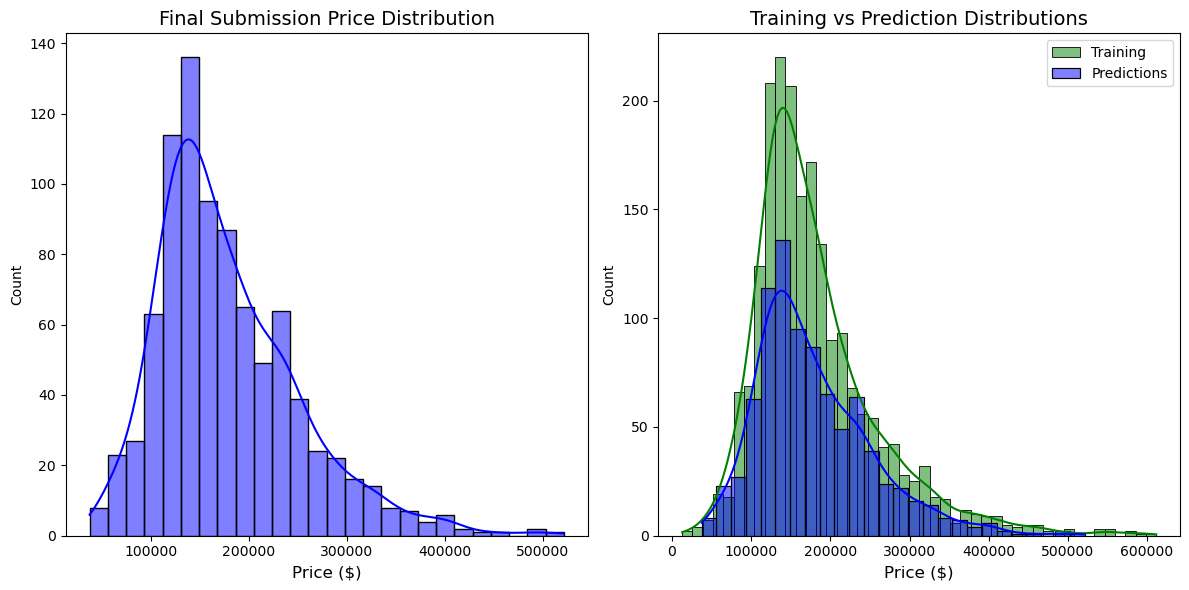


=== SUBMISSION READY ===
Upload ../data/kaggle_submission.csv to the Kaggle competition page.
Instructions:
1. Go to the competition page
2. Click on 'Submit Predictions'
3. Upload the CSV file
4. Add a description (e.g., 'Ridge Regression with Feature Engineering')
5. Click 'Make Submission'


In [6]:
# Save submission
submission_path = '../data/kaggle_submission.csv'
submission.to_csv(submission_path, index=False)
print(f"\nSubmission saved to {submission_path}")

# Final analysis of submission
print("\nFinal submission statistics:")
price_col = 'saleprice' if 'saleprice' in submission.columns else 'SalePrice'
print(f"Total predictions: {len(submission)}")
print(f"Price range: ${submission[price_col].min():.2f} - ${submission[price_col].max():.2f}")
print(f"Mean price: ${submission[price_col].mean():.2f}")
print(f"Median price: ${submission[price_col].median():.2f}")
print(f"Standard deviation: ${submission[price_col].std():.2f}")

# Visualize final submission
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(submission[price_col], kde=True, color='blue')
plt.title('Final Submission Price Distribution', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)

# If we have the original training data, compare distributions
try:
    train = pd.read_csv('../data/train.csv')
    # Standardize column names
    train.columns = train.columns.str.lower().str.replace(' ', '_')
    
    plt.subplot(1, 2, 2)
    train_price_col = 'saleprice' if 'saleprice' in train.columns else 'SalePrice'
    sns.histplot(train[train_price_col], kde=True, color='green', label='Training')
    sns.histplot(submission[price_col], kde=True, color='blue', alpha=0.5, label='Predictions')
    plt.title('Training vs Prediction Distributions', fontsize=14)
    plt.xlabel('Price ($)', fontsize=12)
    plt.legend()
    
except:
    print("Training data not available for distribution comparison.")

plt.tight_layout()
plt.show()

print("\n=== SUBMISSION READY ===")
print(f"Upload {submission_path} to the Kaggle competition page.")
print("Instructions:")
print("1. Go to the competition page")
print("2. Click on 'Submit Predictions'")
print("3. Upload the CSV file")
print("4. Add a description (e.g., 'Ridge Regression with Feature Engineering')")
print("5. Click 'Make Submission'")